In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
from verification.val_db import (get_finalized_validation_datasets,
                                 read_validation_dataset,
                                 get_HLS_id,
                                 get_val_s3_path
                                )
from verification.es_db import get_dswx_urls

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import rasterio
from matplotlib.colors import ListedColormap
from shapely.geometry import box
from rasterio.plot import show

This index is just relative to the finalized datasets.

In [3]:
INDEX = 2

# Table of Finalized Data

In [4]:
df = get_finalized_validation_datasets()
df.head()

,bucket,calc_type,calculated_by,image_calc_name,image_name,notes,oversight_level,previous_name,processing_level,public,reviewed_by,s3_keys,upload_date,version,water_strata,water_stratum,geometry
0,opera-calval-database-dswx,Review,Charlie Marshak,20210903_150800_60_2458_classification_v2,20210903_150800_60_2458,Previous(Previous((CM): Used a NDWI threshold ...,None,20210903_150800_60_2458_classification_v1,Final,True,Alexander Handwerger,data/site/4_21/image/20210903_150800_60_2458/i...,20220930_152559,2.0,NaN,3.0,"POLYGON ((-71.87051 55.11002, -71.87051 55.166..."
1,opera-calval-database-dswx,Review,Alexander Handwerger,20210906_101112_28_225a_classification_v1,20210906_101112_28_225a,Previous(Supervised Classification using Semia...,None,20210906_101112_28_225a_classification_v0,Final,True,Charlie Marshak,data/site/3_28/image/20210906_101112_28_225a/i...,20220929_144718,1.0,NaN,2.0,"POLYGON ((-0.04389 43.05233, -0.04389 43.16776..."
2,opera-calval-database-dswx,Review,Matthew Bonnema,20210912_034049_22_2421_classification_v1,20210912_034049_22_2421,Previous(Classified using NDWI and manual edit...,None,20210912_034049_22_2421_classification_v0,Final,True,Charlie Marshak,data/site/4_8/image/20210912_034049_22_2421/im...,20220929_175551,1.0,NaN,3.0,"POLYGON ((97.58389 49.35489, 97.58389 49.40992..."
3,opera-calval-database-dswx,Review,Alexander Handwerger,20210924_000522_94_2421_classification_v2,20210924_000522_94_2421,Previous(None) (CM): A scene predominantly oce...,None,None,Final,True,Charlie Marshak,data/site/4_42/image/20210924_000522_94_2421/i...,20220929_155401,2.0,NaN,3.0,"POLYGON ((139.64244 -17.06008, 139.64244 -16.9..."
4,opera-calval-database-dswx,Review,Charlie Marshak,20210927_105543_66_2424_classification_v1,20210927_105543_66_2424,Previous(Totally dry scene) No changes,None,20210927_105543_66_2424_classification_v0,Final,True,Alexander Handwerger,data/site/1_32/image/20210927_105543_66_2424/i...,20220928_162812,1.0,NaN,0.0,"POLYGON ((-6.60296 14.85119, -6.60296 14.90600..."


In [5]:
f'Currently, there are {df.shape[0]} finalized datasets'

'Currently, there are 17 finalized datasets'

Use the `INDEX` to select a planet id.

In [6]:
planet_ids = df.image_name.tolist()
planet_id = planet_ids[INDEX]
planet_id

'20210912_034049_22_2421'

# Read a Validation Dataset

In [7]:
X_val, p_val = read_validation_dataset(planet_ids[INDEX])
p_val

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 255.0, 'width': 2001, 'height': 2001, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(3.0, 0.0, 391161.0,
       0.0, -3.0, 5473992.0), 'tiled': False, 'compress': 'lzw', 'interleave': 'band'}

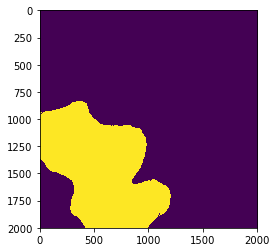

In [8]:
Y = X_val.astype(float)
Y[Y == 255] = np.nan
plt.imshow(Y, interpolation='none')

# Get Associated HLS Id

In [9]:
hls_ids = [get_HLS_id(p_id) for p_id in tqdm(planet_ids)]
hls_ids[:3]

100%|██████████| 17/17 [00:00<00:00, 55.03it/s]


['HLS.L30.T18UXG.2021245T154154.v2.0',
 'HLS.S30.T30TYN.2021248T105621.v2.0',
 'HLS.S30.T47ULQ.2021254T043701.v2.0']

# Get DSWx Products

In [10]:
dswx_urls = get_dswx_urls(hls_ids[2])
dswx_urls

/Users/cmarshak/opt/anaconda3/lib/python3.8/site-packages/elasticsearch/connection/http_urllib3.py:204: UserWarning: Connecting to https://100.104.62.10:443 using SSL with verify_certs=False is insecure.
  warnings.warn(
/Users/cmarshak/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
/Users/cmarshak/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host '100.104.62.10'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


['https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20220909T222103Z_S2A_30_v0.1/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20220909T222103Z_S2A_30_v0.1_B01_WTR.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20220909T222103Z_S2A_30_v0.1/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20220909T222103Z_S2A_30_v0.1_B02_BWTR.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20220909T222103Z_S2A_30_v0.1/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20220909T222103Z_S2A_30_v0.1_B03_CONF.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20220909T222103Z_S2A_30_v0.1/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_20220909T222103Z_S2A_30_v0.1_B04_DIAG.tiff',
 'https://opera-pst-rs-pop1.s3.us-west-2.amazonaws.com/products/OPERA_L3_DSWx_HLS_T47ULQ_20210911T043701Z_2022090

In [11]:
with rasterio.open(dswx_urls[0]) as ds:
    X_dswx = ds.read(1)
    p_dswx = ds.profile
    crs_dswx = ds.crs
    colormap = ds.colormap(1)
    dswx_crs = ds.crs

(-0.5, 3659.5, 3659.5, -0.5)

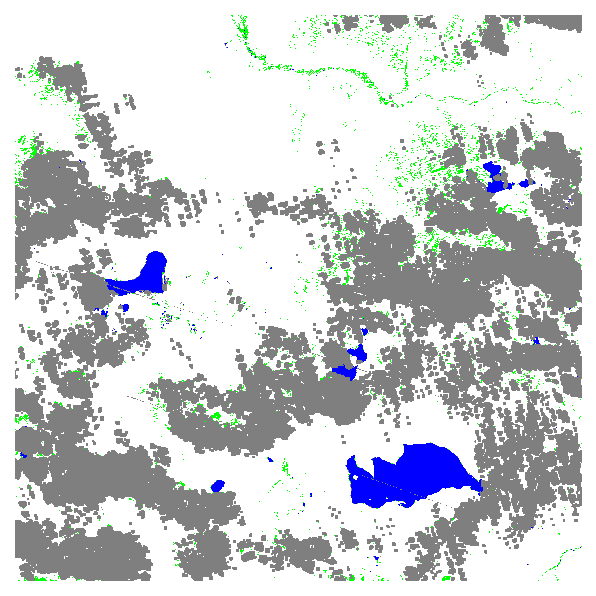

In [12]:
plt.figure(dpi=150, figsize=(5, 5))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])
plt.imshow(X_dswx, cmap=cmap, 
           interpolation='none', 
           vmin=0)
plt.axis('off')


# Compare Extents

Inspect the DSWx Subset and its corresponding Validation Dataset

In [13]:
val_url = get_val_s3_path(planet_id)
with rasterio.open(val_url) as ds:
    val_bounds = list(ds.bounds)
    val_crs = ds.crs

In [14]:
df_val_bounds = gpd.GeoDataFrame(geometry=[box(*val_bounds)],
                                 crs=val_crs)
df_val_bounds

,geometry
0,"POLYGON ((397164.000 5467989.000, 397164.000 5..."


Text(0.5, 1.0, 'Validation Dataset')

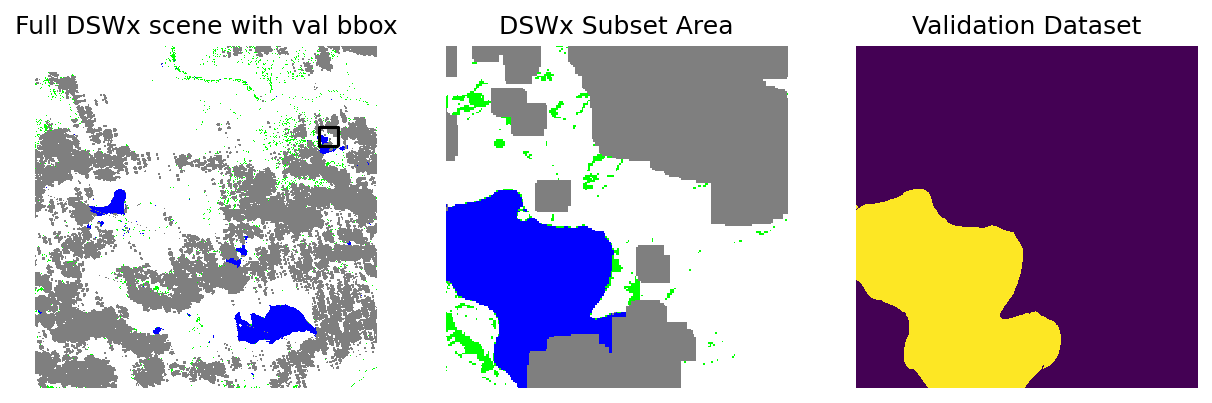

In [15]:
fig, ax = plt.subplots(1, 3, dpi=150, figsize=(10, 10))
cmap = ListedColormap([np.array(colormap[key]) / 255 for key in range(256)])

show(X_dswx, cmap=cmap, transform=p_dswx['transform'], vmin=0, interpolation='none', ax=ax[0])
df_val_bounds.to_crs(crs_dswx).boundary.plot(ax=ax[0], color='black')
ax[0].axis('off')
ax[0].set_title('Full DSWx scene with val bbox')

show(X_dswx, cmap=cmap, transform=p_dswx['transform'], vmin=0, interpolation='none', ax=ax[1])
ax[1].set_xlim(val_bounds[0], val_bounds[2])
ax[1].set_ylim(val_bounds[1], val_bounds[3])
ax[1].set_title('DSWx Subset Area')
ax[1].axis('off')


show(X_val, transform=p_val['transform'], ax=ax[2], interpolation='none')
ax[2].axis('off')
ax[2].set_title('Validation Dataset')


In [16]:
# def get_dswx_wtr_url(planet_id):
#     hls_id = get_HLS_id(planet_id)
#     try:
#         return get_dswx_urls(hls_id)[0]
#     except ValueError:
#         return 'Unavailable'
# df['dswx_wtr_url'] = df.image_name.map(get_dswx_wtr_url)
# df.head()

In [17]:
# df.to_file('current_finalized_datasets.geojson', driver='GeoJSON')